In [209]:
import os
os.chdir(os.getenv("WORKINGDIR"))
from tqdm.notebook import tqdm
import concurrent.futures
import numpy as np
from numpy.typing import ArrayLike
from scipy.optimize import curve_fit
from scipy.stats import chi2
import pandas as pd
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns
from skipper_image_analysis.utils import (
    correct_overscan, get_rowcol_ovserscan
)

# from scipy.signal import peak_prominences, peak_widths


def intensidad_func(tph, tau, Pc):
    npump = 40000
    return npump*Pc*(np.exp(-tph/tau) - np.exp(-2*tph/tau))


def gaussiana(x, amplitud, mu, sigma):
    return amplitud * np.exp(-(x - mu)**2/(2*sigma**2))


def tau_func(T, e_kb, tau_0):
    return tau_0/(T**2)*np.exp(e_kb/T)


# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"


GANANCIA = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}
PRESCAN_PIX = 8

CARPETAS_POR_TEMP: dict[str, list[str]] = {
    127: ["skipper_data/TRAPS/19NOV2023_127K/", "skipper_data/TRAPS/20NOV2023_127K/",],
    135: ["skipper_data/TRAPS/27NOV2023_135K/",],
    140: ["skipper_data/TRAPS/23NOV2023_140K/",],
    145: ["skipper_data/TRAPS/25NOV2023_145K/",],
    150: ["skipper_data/TRAPS/22NOV2023_150K/",],
    160: ["skipper_data/TRAPS/12DIC2023_160K/",],
    165: ["skipper_data/TRAPS/06DIC2023_165K/", "skipper_data/TRAPS/07DIC2023_165K/", "skipper_data/TRAPS/09DIC2023_165K/",],
}
RESULTS_DIR = "skipper_image_analysis/TRAPS_results"
CLOCKS_TO_SEC = 15e6  # Hz
DTPH_VALS = np.array([50, 75, 100, 150, 200, 300, 400, 600, 800, 1200, 1600, 2400, 3200, 4800, 6400, 9600, 12800, 19200, 25600, 38400, 51200])
# Define Bins so that each value is at the center of the bin in a log scale
DTPH_BINS = np.sqrt(DTPH_VALS[1:] * DTPH_VALS[:-1])
DTPH_BINS = np.insert(DTPH_BINS, 0, DTPH_VALS[0]*0.8)
DTPH_BINS = np.append(DTPH_BINS, DTPH_VALS[-1]*1.2)

# for bin in DTPH_BINS/CLOCKS_TO_SEC:
#     plt.axvline(bin, color="k")
# for val in DTPH_VALS/CLOCKS_TO_SEC:
#     plt.axvline(val, color="r")
# plt.xscale("log")
# plt.show()

In [210]:
def plot_region_con_margenes(
    main_ax_data: ArrayLike,
    x_margin_data: ArrayLike,
    y_margin_data: ArrayLike,
    main_ax_aspect=1,
) -> tuple[plt.Figure, plt.Axes, plt.Axes, plt.Axes]:
    # Create a Figure, which doesn't have to be square.
    fig = plt.figure(layout='constrained')
    # Create the main axes, leaving 25% of the figure space at the top and on the
    # right to position marginals.
    main_ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
    # Create marginal axes, which have 25% of the size of the main axes.  Note that
    # the inset axes are positioned *outside* (on the right and the top) of the
    # main axes, by specifying axes coordinates greater than 1.  Axes coordinates
    # less than 0 would likewise specify positions on the left and the bottom of
    # the main axes.
    x_ax = main_ax.inset_axes([0, 1.0, 1, 0.25])
    x_ax.tick_params(axis='x', labelbottom=False, bottom=False)
    y_ax = main_ax.inset_axes([1.0, 0, 0.25, 1])
    y_ax.tick_params(axis='y', labelleft=False, left=False)
    # Draw the scatter plot and marginals.
    main_ax.imshow(
        main_ax_data,
        aspect=main_ax_aspect,
        origin='lower',
    )
    if x_margin_data.size == main_ax_data.shape[1]:
        x_ax.plot(np.arange(main_ax_data.shape[1]), x_margin_data)
        x_ax.sharex(main_ax)
    else:
        x_ax.plot(x_margin_data)
    if y_margin_data.size == main_ax_data.shape[0]:
        y_ax.plot(y_margin_data, np.arange(main_ax_data.shape[0]))
        y_ax.sharey(main_ax)
    else:
        y_ax.plot(y_margin_data, range(len(y_margin_data)))
    return fig, main_ax, x_ax, y_ax

skipper_data/TRAPS/27NOV2023_135K/proc_skp_pocket_oled1row_2film_dTph4800_NPUPMPS40000_NSAMP20_NROW879_NCOL336_EXPOSURE8.0_img281.fits


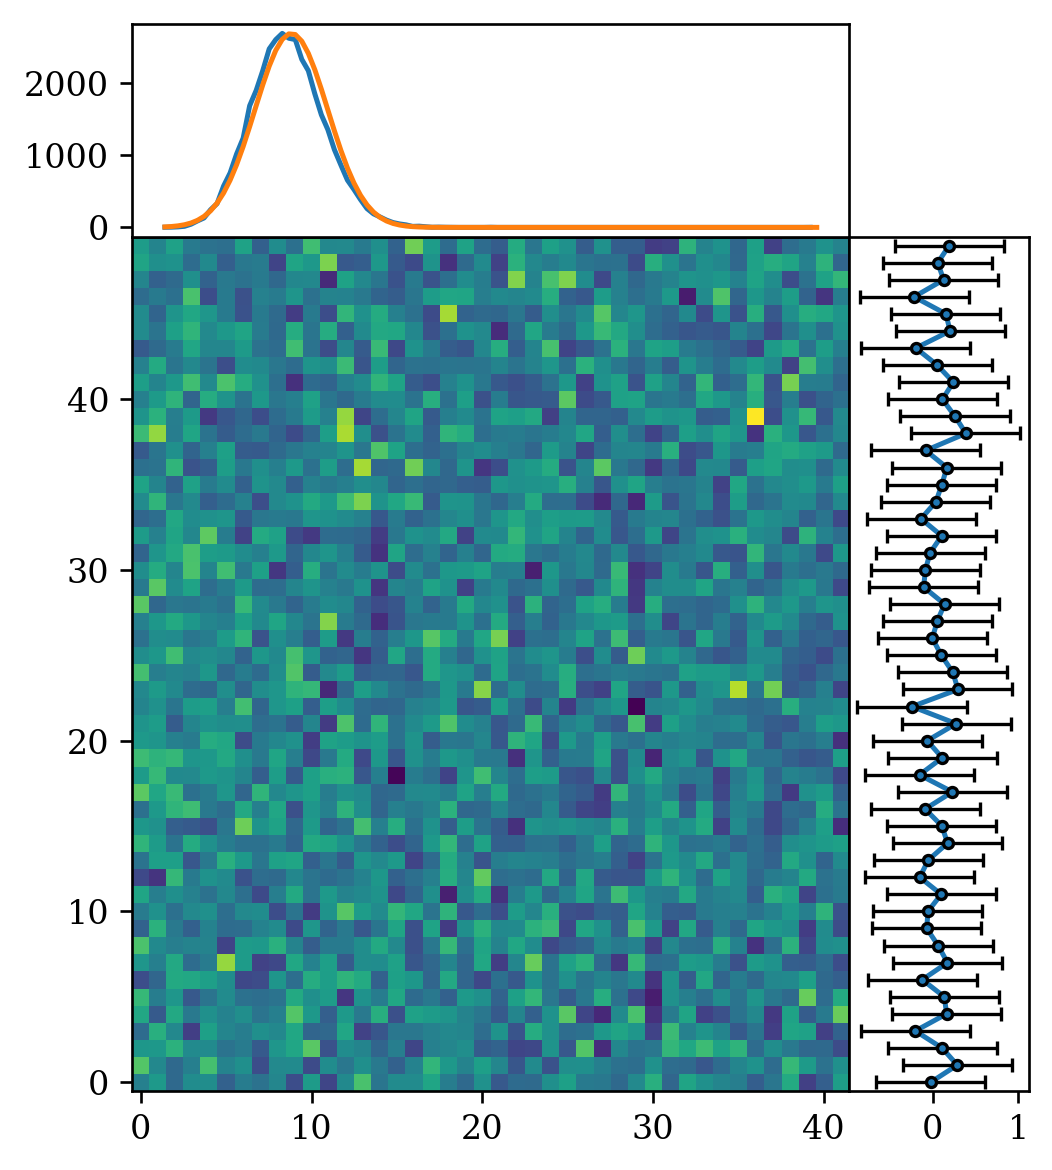

In [211]:
data_dir = CARPETAS_POR_TEMP[135][0]
files_in_dir = os.listdir(data_dir)
test_image = fits.open(f'{data_dir}/{files_in_dir[0]}')
print(data_dir, files_in_dir[0], sep="")
row_overscan_len, col_overscan_len = get_rowcol_ovserscan(test_image)
test_frame = test_image[0]



# data = test_frame.data[1:-row_overscan_len, PRESCAN_PIX:-col_overscan_len]  # Área activa
overscan_data = test_frame.data[:, -col_overscan_len:]  # Overscan en columnas
overscan_data = overscan_data.copy()/GANANCIA[0]
error_lectura = np.std(overscan_data, ddof=1)
plot_data = overscan_data[200:250, :]

counts, edges = np.histogram(
        overscan_data, bins=100
    )
fig, main_ax, x_ax, y_ax = plot_region_con_margenes(
    plot_data,
    x_margin_data=counts,
    y_margin_data=plot_data.mean(axis=1),
    main_ax_aspect=1,
)
y_ax.errorbar(
    plot_data.mean(axis=1),
    np.arange(plot_data.shape[0]),
    xerr=error_lectura/np.sqrt(plot_data.shape[1]),
    fmt='.C0',
    markeredgecolor="k",
    ecolor='k',
    elinewidth=1,
    capsize=2,
)
x_ax.plot(
    gaussiana(
        edges,
        counts.max(),
        overscan_data.mean(),
        overscan_data.std(ddof=1)
    ),
)

plt.show()

In [212]:
def prepare_frame(
    skipper_image: fits.hdu.hdulist.HDUList,
    frame_idx: int,
    remove_row_median: bool = True,
) -> ArrayLike:
    global GANANCIA, PRESCAN_PIX
    r_overscan, c_overscan = get_rowcol_ovserscan(skipper_image)
    # Extract Read Error from Column Overscan
    overscan_frame = (
        skipper_image[frame_idx].data[:, -c_overscan:]
        / GANANCIA[frame_idx]
    )  # e⁻
    # Fit Gaussian to Column Overscan Distribution
    charge_frec, charge_bins = np.histogram(
        overscan_frame.flatten(),
        bins=np.linspace(
            overscan_frame.min(),
            np.min([overscan_frame.max(), -overscan_frame.min()]),
            500
        ),
        density=True,
    )
    try:  # Try to fit a Gaussian to the distribution
        popt, _ = curve_fit(
            gaussiana,
            charge_bins[:-1],
            charge_frec,
            p0=[1/np.sqrt(2*np.pi*4), 0, overscan_frame.std()],
        )
        error = np.abs(popt[2])  # e⁻
    except RuntimeError:  # If the fit fails, use the standard deviation and plot
        error = overscan_frame.std()  # e⁻
        # plt.plot(charge_bins[:-1], charge_frec, ".")
        # plt.plot(charge_bins[:-1], gaussiana(charge_bins[:-1], *popt))
        # plt.show()
    # Correct Baseline from Overscan in Rows and Columns
    skipper_image = correct_overscan(skipper_image)  # A.D.U.
    frame = skipper_image[frame_idx].data  # A.D.U.
    frame = frame[1:-r_overscan, PRESCAN_PIX:-c_overscan]  # A.D.U.
    if remove_row_median:
        # Remove the median of each row so that the median of the frame is zero
        frame = frame - np.median(frame, axis=1, keepdims=True)  # A.D.U.
    
    error_final = error * np.sqrt(
        1 + 1/r_overscan + 1/c_overscan + 1/frame.shape[1]
    )  # e⁻: Error propagado tras aplicar todas las correcciones
    return frame/GANANCIA[frame_idx], error_final # e⁻

In [213]:
def filtro_dipolos(
    frame: ArrayLike,
    threshold: float = 5e5,  # e⁻
    corte_simetria: float = 20,  # %
) -> tuple[list, list, ArrayLike]:  # ACTUALIZAR EN CÓDIGO!
    """Busca dipolos en un frame de la CCD. Para ello, se calcula el producto entre \
cada pixel y su vecino inferior. Si el producto es menor que un umbral negativo, se \
considera que hay un dipolo. Luego, se revisa que el dipolo sea simétrico, es decir, \
que los valores de los pixeles sean similares en magnitud. Si el dipolo es simétrico, \
se agrega a la lista de dipolos encontrados. Finalmente, se devuelve una lista con \
las coordenadas de los dipolos, una máscara con los dipolos encontrados y una lista \
con los valores de los dipolos.

    Parameters:
    -----------

        `frame {ArrayLike}`: Frame de la CCD a analizar. Debe estar en unidades de \
electrones.

        `threshold {float, optional}`: Valor umbral en la clasificación de picos. \
Valor por defecto = 500_000.

        `corte_simetria {float, optional}`: Defaults to 20.

    Returns:
    --------

        `{tuple[list, list, ArrayLike]}`:
    """
    prod_arr = frame[:-1] * frame[1:]
    val_trampas = []
    coordenadas_trampas = []
    mascara = np.zeros_like(frame)
    for j, col in enumerate(prod_arr.T):  # Recorro las columnas del frame
        for i, val in enumerate(col):  # Recorro los valores de cada columna
            if val < -threshold:
                # Reviso que no esté en el borde del frame
                if i == 0:
                    i_lleno = np.argmax(frame[i:i+2, j])
                    i_lleno += i - 1
                    i_vacio = np.argmin(frame[i:i+2, j])
                    i_vacio += i - 1
                elif i == len(col):
                    i_lleno = np.argmax(frame[i-1:i+1, j])
                    i_lleno += i - 1
                    i_vacio = np.argmin(frame[i-1:i+1, j])
                    i_vacio += i - 1
                else:
                    i_lleno = np.argmax(frame[i-1:i+2, j])
                    i_lleno += i - 1
                    i_vacio = np.argmin(frame[i-1:i+2, j])
                    i_vacio += i - 1
                if np.abs(i_lleno-i_vacio) == 1:  # Confirmo adyacencia
                    val_1  = frame[i_lleno, j]
                    val_2 = frame[i_vacio, j]
                    diferencia_relativa = np.abs(
                        100
                        * (np.abs(val_1) - np.abs(val_2))
                        / np.max([np.abs(val_1), np.abs(val_2)])
                    )
                    if diferencia_relativa < corte_simetria:  # filtro por simetría
                        coordenadas_trampas.append(((i_lleno, j), (i_vacio, j)))
                        val_trampas.append(np.abs(val_1 - val_2) / 2)
                        mascara[i_lleno, j] = 1
                        mascara[i_vacio, j] = 1
                if (i_lleno < 0) or (i_vacio < 0):
                    print(i_lleno, i_vacio, j)
                     
    return coordenadas_trampas, val_trampas, mascara

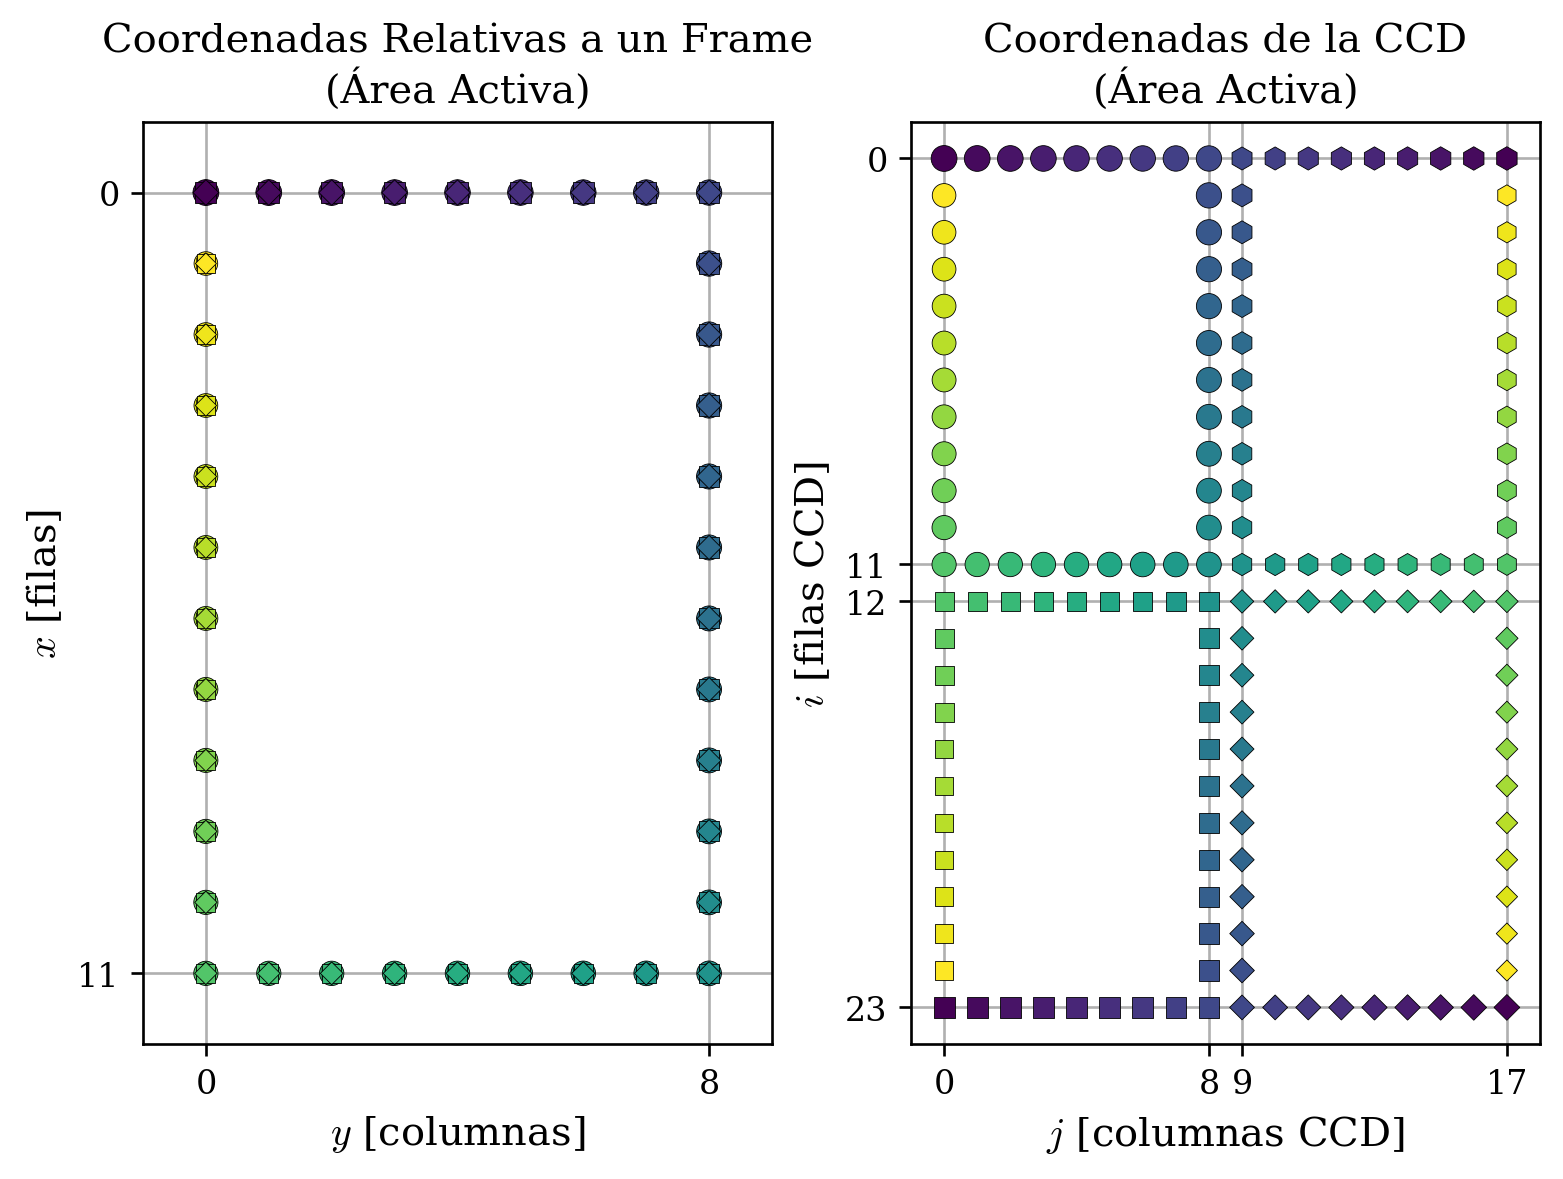

In [214]:
def frame_coords_to_ccd_coords(
    coord: tuple[int, int], frame_idx: int, CCDNROWS: int, CCDNCOLS: int
) -> tuple[int, int]:
    """Transforma las coordenadas relativas a un frame a las coordenadas de la \
CCD considerando el frame y el overscan.
    """
    x, y = coord
    row = x
    col = y
    if frame_idx in [1, 3]:
        col = CCDNCOLS - y - 1
    if frame_idx in [2, 3]:
        row = CCDNROWS - x - 1
    return row, col


def ccd_coords_to_frame_coords(
    coord: tuple[int, int], frame_idx: int, CCDNROWS: int, CCDNCOLS: int
) -> tuple[int, int]:
    """Transforma las coordenadas relativas a la CCD a las coordenadas de un \
frame considerando el frame y el overscan.
    """
    row, col = coord
    y = col
    x = row
    if frame_idx in [1, 3]:
        y = CCDNCOLS - col - 1
    if frame_idx in [2, 3]:
        x = CCDNROWS - row - 1
    return x, y

CCDNROW = 24
CCDNCOL = 18
test_coords = [
    (0, y) for y in range(CCDNCOL//2 - 1)
] + [
    (x, CCDNCOL//2 - 1) for x in range(CCDNROW//2)
] + [
    (CCDNROW//2 - 1, y) for y in range(CCDNCOL//2 - 1)
][::-1] + [
    (x, 0) for x in range(1, CCDNROW//2 - 1)
][::-1]
x_vals = []
y_vals = []
i_vals = []
j_vals = []
for frame_idx in range(4):
    for x, y in test_coords:
        i, j = frame_coords_to_ccd_coords((x, y), frame_idx, CCDNROW, CCDNCOL)
        i_vals.append(i)
        j_vals.append(j)
        x, y = ccd_coords_to_frame_coords((i, j), frame_idx, CCDNROW, CCDNCOL)
        x_vals.append(x)
        y_vals.append(y)


fig, axs = plt.subplots(1, 2, layout="constrained")
colors_index = np.linspace(0, 1, len(x_vals)//4)
sizes_index = np.linspace(60, 20, len(x_vals))
markers = ["o", "h", "s", "D"]
axs[0].set_title("Coordenadas Relativas a un Frame\n(Área Activa)")

for frame_idx, x_batch, y_batch, markerstyle, sizes in zip(
    range(4), np.array_split(x_vals, 4), np.array_split(y_vals, 4), markers, np.array_split(sizes_index, 4)
):
    axs[0].scatter(
        y_batch, x_batch, c=colors_index, s=sizes, marker=markerstyle,
        alpha=1, edgecolors="k", linewidths=0.25, zorder=25,
        label=f"Frame {frame_idx}"
    )
axs[0].grid()
axs[0].set_yticks([CCDNROW//2 - 1, 0])
axs[0].set_ylim(CCDNROW//2, -1)
axs[0].set_ylabel("$x$ [filas]")
axs[0].set_xticks([0, CCDNCOL//2 - 1])
axs[0].set_xlim(-1, CCDNCOL//2)
axs[0].set_xlabel("$y$ [columnas]")

axs[1].set_title("Coordenadas de la CCD\n(Área Activa)")
for frame_idx, i_batch, j_batch, markerstyle, sizes in zip(
    range(4), np.array_split(i_vals, 4), np.array_split(j_vals, 4), markers, np.array_split(sizes_index, 4)
):
    axs[1].scatter(
        j_batch, i_batch, c=colors_index, s=sizes, marker=markerstyle,
        alpha=1, edgecolors="k", linewidths=0.25, zorder=25,
        label=f"Frame {frame_idx}"
    )
axs[1].grid()
axs[1].set_yticks([0, CCDNROW//2 - 1, CCDNROW//2, CCDNROW - 1])
axs[1].set_ylim(CCDNROW, -1)
axs[1].set_ylabel("$i$ [filas CCD]")
axs[1].set_xticks([0, CCDNCOL//2 - 1, CCDNCOL//2, CCDNCOL - 1])
axs[1].set_xlim(-1, CCDNCOL)
axs[1].set_xlabel("$j$ [columnas CCD]")
# axs[1].xaxis.set_label_position("top")
# axs[1].xaxis.tick_top()
plt.show()

In [215]:
def carga_archivos(
    temperatura: int, dir_idx: int, frame_idx: int,
    threshold: float = 5e5, corte_simetria: float = 20
) -> tuple[dict, dict, dict, dict, fits.hdu.hdulist.HDUList, dict]:
    """Carga los archivos de una carpeta de una temperatura y un número de archivo \
específicos. Luego, aplica el filtro de dipolos a cada frame y devuelve las \
coordenadas de los dipolos, los valores de los dipolos, una máscara con los dipolos \
encontrados, el objeto fits con los datos de la CCD en la última imagen procesada y \
un diccionario con los errores de cada frame.

    Parameters:
    -----------

        `temperatura {int}`: Temperatura de la CCD en Kelvin durante la toma de datos.

        `dir_idx {int}`: Índice de la carpeta con los archivos a cargar cuando existe \
más de una carpeta por temperatura.

        `frame_idx {int}`: Índice del frame/cuadrante de la CCD a analizar.

        `threshold {float, optional}`: Umbrál en (e⁻)² para la detección de dipolos. \
Valor por defecto = 500_000.

        `corte_simetria {float, optional}`: Porcentaje de la diferencia en simetría \
para el filtro en la detección de dipolos. Valor por defecto = 20.

    Returns:
    --------

        `{tuple[dict, dict, dict, dict, fits.hdu.hdulist.HDUList, dict]}`: Diccionarios\
 con las coordenadas de los dipolos, los valores de los dipolos, una máscara con los \
dipolos encontrados, el objeto fits con los datos de la CCD en la última imagen y un \
diccionario con los errores de cada frame.
    """
    global CARPETAS_POR_TEMP
    # Cargar Archivos desde sus Carpetas por Temperatura
    data_dir = CARPETAS_POR_TEMP[temperatura][dir_idx]
    files_in_dir = os.listdir(data_dir)
    valid_formats = ["fits",]
    files_in_dir = [f for f in files_in_dir if f.rsplit(".")[-1] in valid_formats]
    frames_dict = dict()
    error_dict = dict()
    coords_dict = dict()
    vals_dict = dict()
    mascara_dipolos = dict()
    for file in tqdm(files_in_dir, desc="Procesando Archivos", leave=False):
        dtph = int(file.rsplit("_")[5][4:])
        if dtph in coords_dict:
            continue
        test_image = fits.open(f'{data_dir}/{file}')
        frames_dict[dtph], error_dict[dtph] = prepare_frame(test_image, frame_idx)  # e⁻
        if error_dict[dtph] > 1e3:  # Si el error es muy grande, descartar el frame
            # Por el NSAMP=20 sabemos que el error de lectura es del orden de 10 e⁻
            del frames_dict[dtph], error_dict[dtph]
            continue
        coords_dict[dtph], vals_dict[dtph], mascara_dipolos[dtph] = filtro_dipolos(
            frames_dict[dtph], threshold, corte_simetria
        )
    return coords_dict, frames_dict, vals_dict, error_dict, mascara_dipolos, test_image

In [216]:
def identificacion_e_intensidad(coords_dict, frames_dict, errors_dict):
    """Identifica trampas en todos los dtph y busca la intensidad
    de cada trampa en todos los dtph"""
    trampas_halladas = []
    intensidad_por_trampa = []
    dtph_vals = list(coords_dict.keys())
    dtph_vals = [dtph_vals[i] for i in np.argsort(dtph_vals)]
    error_vals = [  # e⁻
        errors_dict[dtph]/np.sqrt(2) for dtph in dtph_vals
    ]  # Error propagado al calcular la intensidad como la mitad de la diferencia
    for dtph in tqdm(
        dtph_vals[::-1],
        desc="Recorriendo dTph",
        total=len(dtph_vals),
        leave=False,
    ):
        coordenadas_trampas = coords_dict[dtph]
        for coords in coordenadas_trampas:
            if coords in trampas_halladas:
                continue
            trampas_halladas.append(coords)
            intensidades_trampa = []
            for dtph_frames in dtph_vals:
                frame = frames_dict[dtph_frames]
                intensidades_trampa.append(np.abs(frame[coords[0]]-frame[coords[1]])/2)
            intensidad_por_trampa.append(intensidades_trampa)
    return trampas_halladas, intensidad_por_trampa, dtph_vals, error_vals

## Análisis de la Intensidad de las Trampas (Modelo + Máximos)

In [217]:
def process_temperature(temperatura, carpetas):
    trampas = []  # trampas[dir_idx][coord_idx]
    intensidad = []  # intensidad[dir_idx][coord_idx][dtph_idx]
    dtph = []  # dtph[dir_idx][dtph_idx]
    error = []  # error[dir_idx][dtph_idx]
    for dir_idx in range(len(carpetas)):
        print(f"Procesando Carpeta {carpetas[dir_idx]}...")
        for frame_idx in [0, 1]:
            print(f"Recorriendo Frame {frame_idx}...")
            coords_dict, frames_dict, _, errors_dict, _, test_image = carga_archivos(
                temperatura, dir_idx, frame_idx
            )
            trampas_halladas, intensidad_por_trampa, dtph_vals, error_vals = identificacion_e_intensidad(
                coords_dict, frames_dict, errors_dict
            )
            # Transformamos las coordenadas de los dipolos al sistema de coords de la CCD
            CCDNROW = int(test_image[frame_idx].header["CCDNROW"])
            CCDNCOL = int(test_image[frame_idx].header["CCDNCOL"])
            trampas_halladas = [
                (
                    frame_coords_to_ccd_coords(coords[0], frame_idx, CCDNROW, CCDNCOL),
                    frame_coords_to_ccd_coords(coords[1], frame_idx, CCDNROW, CCDNCOL),
                ) for coords in trampas_halladas
            ]
            trampas.append(trampas_halladas)
            intensidad.append(intensidad_por_trampa)
            dtph.append(dtph_vals)
            error.append(error_vals)
    return trampas, intensidad, dtph, error, temperatura

try:
    trampas_temp = pickle.load(open(f"{RESULTS_DIR}/trampas.pkl", "rb"))
    intensidades_temp = pickle.load(open(f"{RESULTS_DIR}/intensidades.pkl", "rb"))
    dtph_temp = pickle.load(open(f"{RESULTS_DIR}/dtph.pkl", "rb"))
    error_temp = pickle.load(open(f"{RESULTS_DIR}/error.pkl", "rb"))
    print(f"Resultados intermedios cargados desde Pickles en {RESULTS_DIR}")
except FileNotFoundError:
    trampas_temp: dict[int, list[list[tuple[tuple[int]]]]] = dict()
    intensidades_temp: dict[int, list[list[list[float]]]] = dict()
    dtph_temp: dict[int, list[list[int]]] = dict()
    error_temp: dict[int, list[list[int]]] = dict()
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for temperatura, carpetas in CARPETAS_POR_TEMP.items():
            futures.append(executor.submit(process_temperature, temperatura, carpetas))
        
        for future in concurrent.futures.as_completed(futures):
            trampas, intensidad, dtph, error, temperatura = future.result()
            trampas_temp[temperatura] = trampas
            intensidades_temp[temperatura] = intensidad
            dtph_temp[temperatura] = dtph
            error_temp[temperatura] = error
    # Save to Pickle
    if not os.path.exists(RESULTS_DIR):
        os.mkdir(RESULTS_DIR)
    with open(f"{RESULTS_DIR}/trampas.pkl", "wb") as file:
        pickle.dump(trampas_temp, file)
    with open(f"{RESULTS_DIR}/intensidades.pkl", "wb") as file:
        pickle.dump(intensidades_temp, file)
    with open(f"{RESULTS_DIR}/dtph.pkl", "wb") as file:
        pickle.dump(dtph_temp, file)
    with open(f"{RESULTS_DIR}/error.pkl", "wb") as file:
        pickle.dump(error_temp, file)


Resultados intermedios cargados desde Pickles en skipper_image_analysis/TRAPS_results


Se hallaron 255 trampas únicas en todos los barridos.


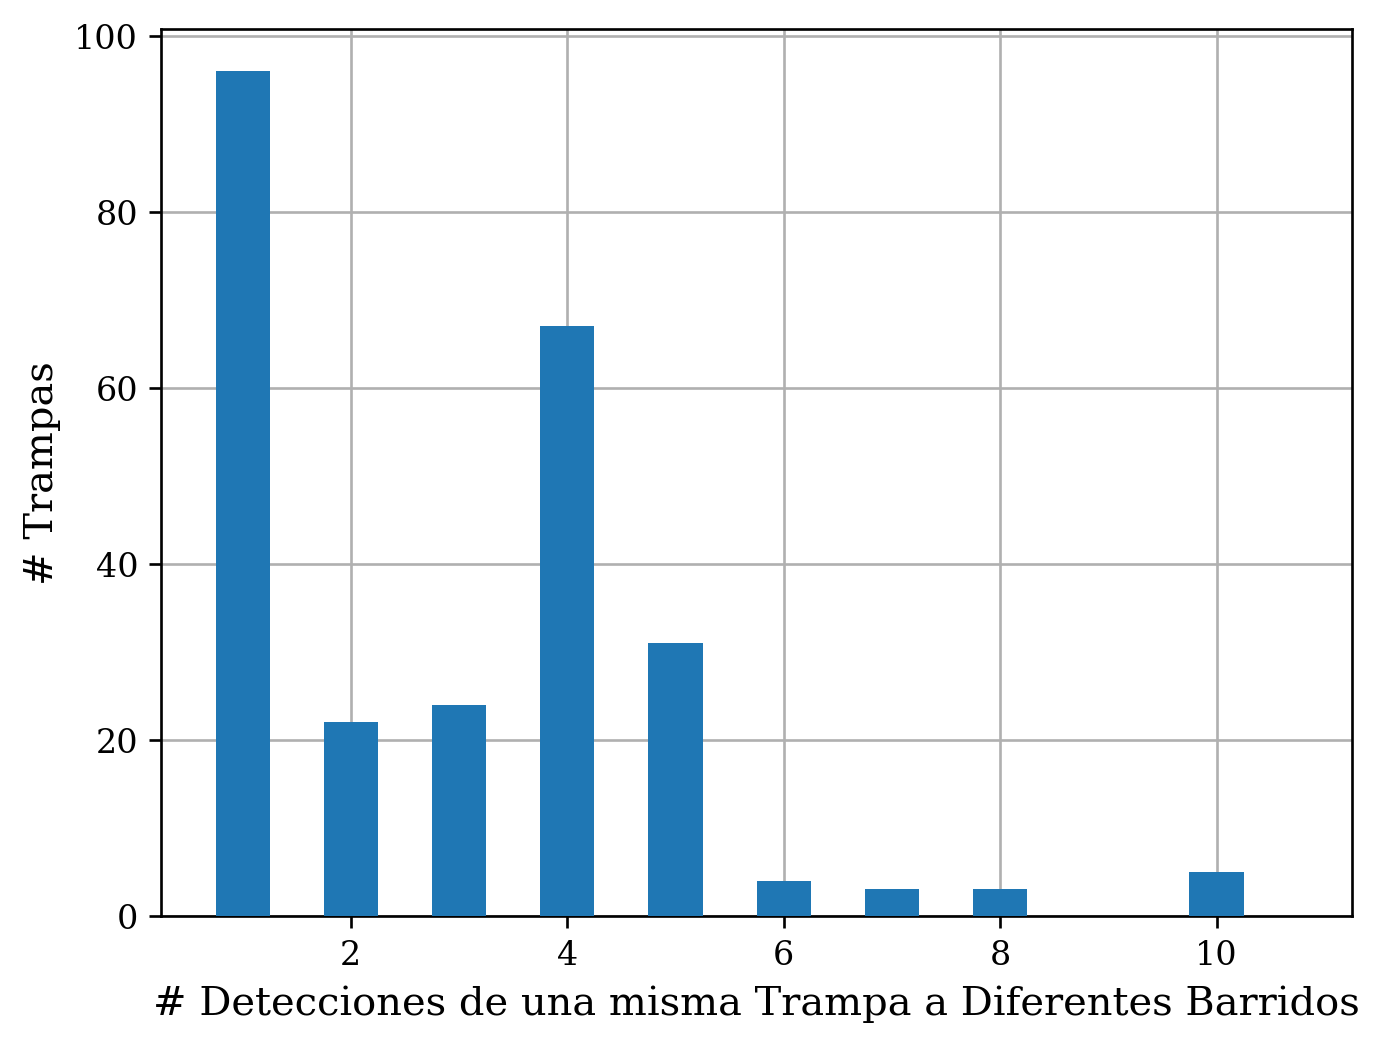

In [218]:
# Busco las trampas que aparecen en múltiples temperaturas
lista_todas_trampas = []
for trampas in trampas_temp.values():
    lista_todas_trampas += trampas
lista_todas_trampas = sum(lista_todas_trampas, start=[])
set_todas_trampas = set(lista_todas_trampas)
print(f"Se hallaron {len(set_todas_trampas)} trampas únicas en todos los barridos.")
repeticiones = []
for trampa in set_todas_trampas:
    repeticiones.append(lista_todas_trampas.count(trampa))
plt.hist(repeticiones, bins=np.arange(1-0.25, 11, 0.5), zorder=5)
plt.grid()
plt.xlabel("# Detecciones de una misma Trampa a Diferentes Barridos")
plt.ylabel("# Trampas")
plt.show()

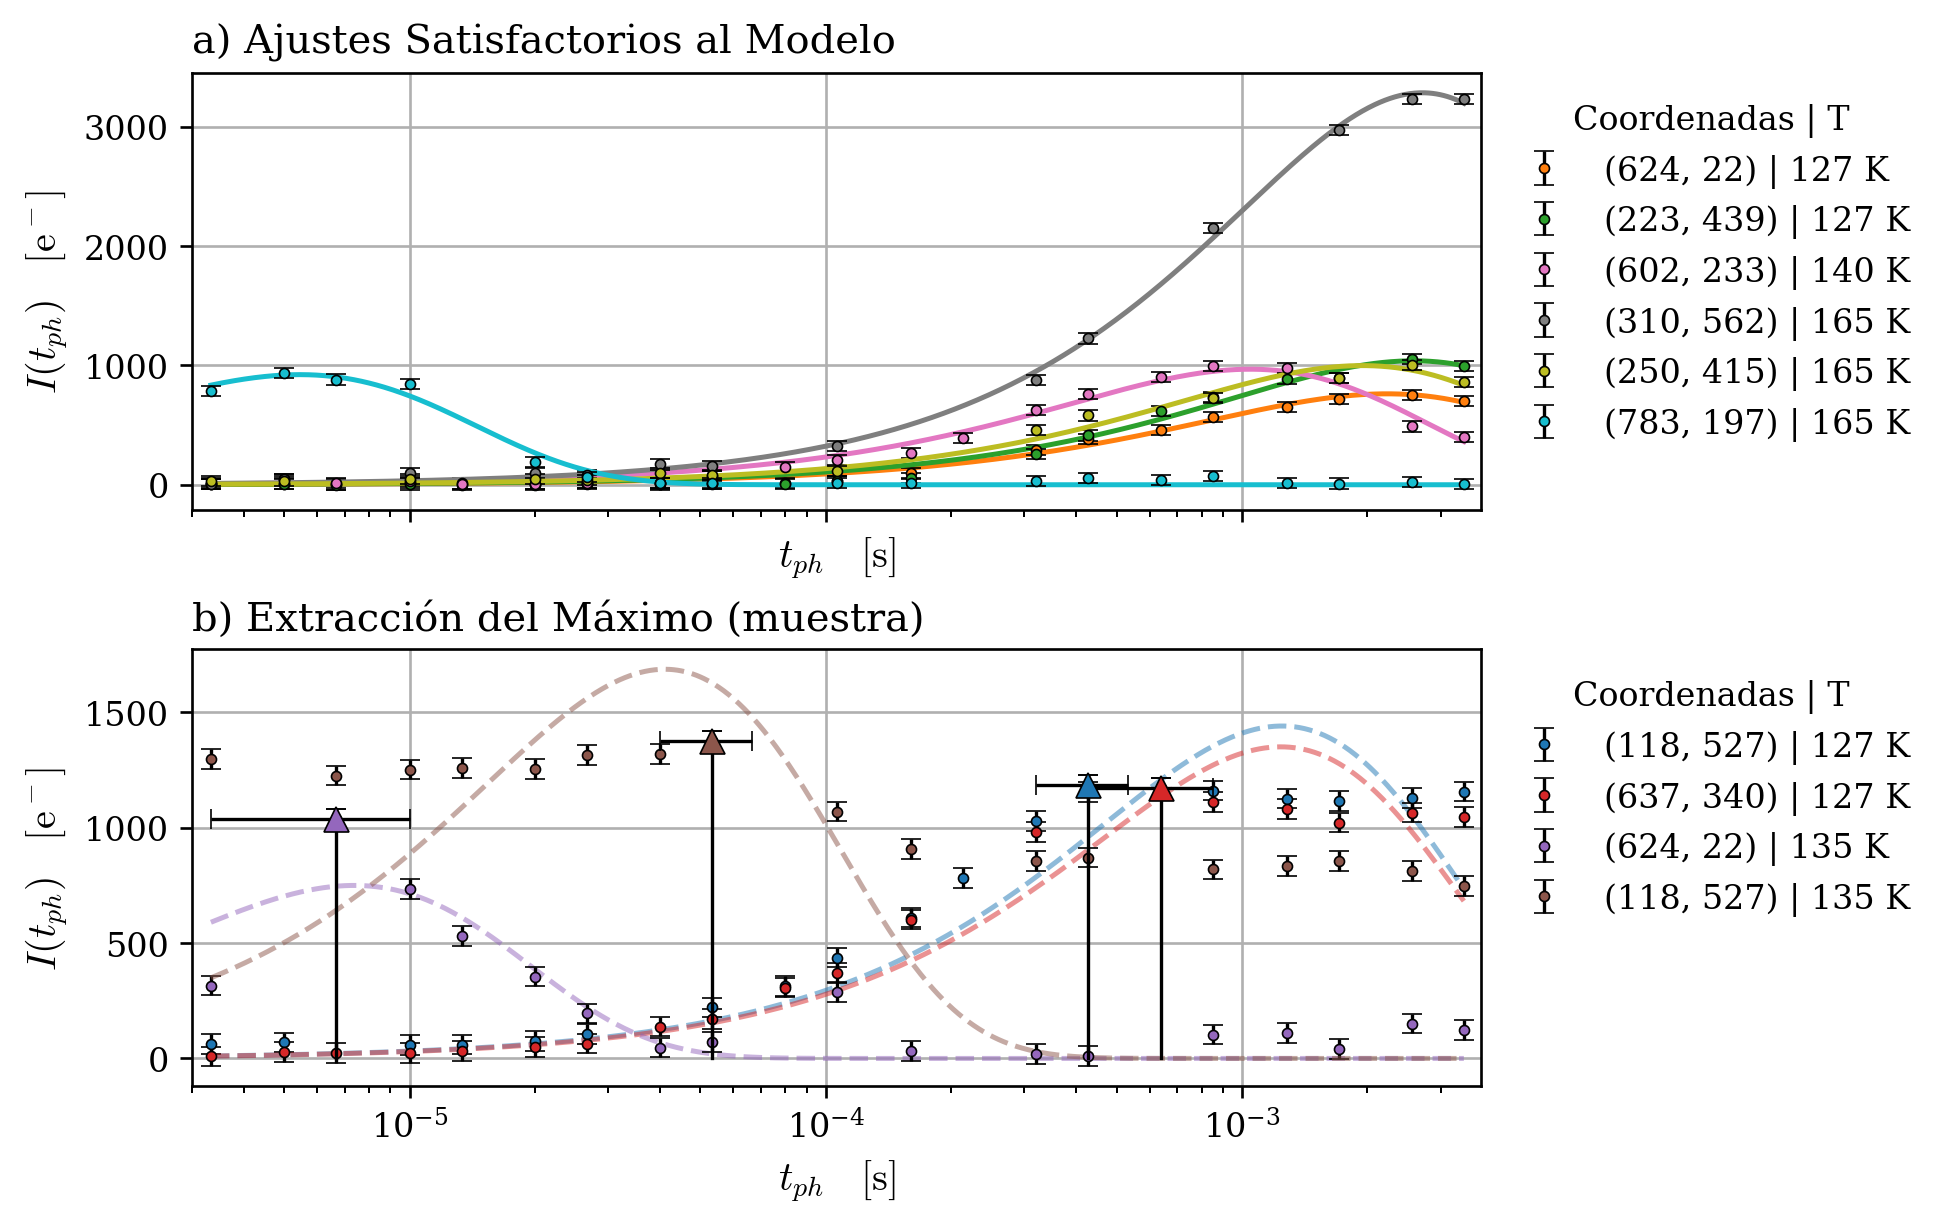

In [227]:
fig, axs = plt.subplots(2, 1, sharex=True, layout="constrained", figsize=(8, 5))
# Para los ajustes satisfactorios
axs[0].set_title("a) Ajustes Satisfactorios al Modelo", loc="left")

plot_idx = 0
skip_plot = False
trampas_ajustadas = []
tau_ajustados = []
err_tau_ajustados = []
temps_datos_ajustados = []
# Para la extracción de máximos
axs[1].set_title("b) Extracción del Máximo (muestra)", loc="left")
plot_count = 0
random_plot_gen = np.random.default_rng(2024)
trampas_seleccionadas = []
maximos_seleccionados = []
error_maximos_seleccionados = []
temps_maximos_seleccionados = []
intensidades_seleccionadas = []
error_intensidades_seleccionadas = []
tph_seleccionados = []
for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    for dir_idx in range(len(carpetas)):
        for frame_idx in [0, 1]:
            dtph_vals = np.array(dtph_temp[temperatura][2*dir_idx + frame_idx])
            error_vals = np.sqrt(
                np.array(error_temp[temperatura][2*dir_idx + frame_idx])**2
                + (60/np.sqrt(2))**2
            )  # Agregando al error de lectura la variación de la intensidad
            dtph_dense = np.geomspace(dtph_vals.min(), dtph_vals.max(), 1000)
            for coord_idx, (coords, intensidades) in enumerate(zip(
                trampas_temp[temperatura][2*dir_idx + frame_idx],
                intensidades_temp[temperatura][2*dir_idx + frame_idx],
            )):
                intensidades = np.array(intensidades)
                idx_pico = np.argmax(intensidades)
                if idx_pico in [0, len(intensidades)-1]:
                    continue
                dtph_maxval = dtph_vals[idx_pico]  # s
                intensidad_maxval = intensidades[idx_pico]  # e⁻
                # Ajustes al Modelo
                tau_estimado = dtph_maxval/np.log(2)  # CLOCKS
                pc_estimado = intensidad_maxval*4/40_000

                popt, pcov = curve_fit(
                    intensidad_func,
                    dtph_vals,
                    intensidades,
                    p0=[tau_estimado, pc_estimado],
                    sigma=error_vals,
                )
                perr = np.sqrt(np.diag(pcov))
                # Chi² del fit
                grados_libertad = len(dtph_vals) - len(popt)
                chi2_obs = np.sum(
                    (
                        (intensidades - intensidad_func(dtph_vals, *popt))
                        / error_vals
                    )**2
                )
                p_value = chi2.sf(chi2_obs, grados_libertad)  # Survival function
                if p_value > 0.05:  # Si el ajuste es satisfactorio
                    if coords[-1] in trampas_ajustadas:  # Si ya ajusté esta trampa
                        # trampa_idx = trampas_ajustadas.index(coords[-1])
                        # color = f"C{trampa_idx%10}"
                        skip_plot = True
                    else:  # Si es una trampa nueva
                        color = f"C{plot_idx%10}"
                        plot_idx += 1
                    trampas_ajustadas.append(coords[-1])
                    tau_ajustados.append(popt[0]/CLOCKS_TO_SEC)  # s
                    err_tau_ajustados.append(perr[0]/CLOCKS_TO_SEC)  # s
                    temps_datos_ajustados.append(temperatura)  # K
                    # Lo que queda del bloque son solo gráficos
                    if not skip_plot:
                        axs[0].plot(
                            dtph_dense/CLOCKS_TO_SEC,
                            intensidad_func(dtph_dense, *popt),
                            c=color,
                        )
                        axs[0].errorbar(
                            dtph_vals/CLOCKS_TO_SEC,
                            intensidades,
                            yerr=error_vals,
                            fmt=f".{color}", label=f"{coords[-1]} | {temperatura} K",
                            markeredgecolor="k", markeredgewidth=0.5,
                            linestyle="",
                            ecolor="k", elinewidth=1, capsize=3,
                        )
                    skip_plot = False
                # Selección de Máximos (filtrando de máximos espurios)
                intensidades_sin_pico = intensidades.copy()
                intensidades_sin_pico[idx_pico] = 0
                idx_pico_2 = np.argmax(intensidades_sin_pico)
                if (
                    (abs(idx_pico_2 - idx_pico) == 1)  # Sus vecinos también son máximos
                    and (intensidades[idx_pico_2]/intensidad_maxval > 0.5)  # El segundo es casi tan alto como el primero
                ):
                    error_determinacion_pico = np.min(
                        np.diff(dtph_vals[idx_pico-1:idx_pico+2])
                    )
                    trampas_seleccionadas.append(coords[-1])
                    maximos_seleccionados.append(dtph_maxval/CLOCKS_TO_SEC)  # s
                    error_maximos_seleccionados.append(error_determinacion_pico/CLOCKS_TO_SEC)  # s
                    temps_maximos_seleccionados.append(temperatura)  # K
                    intensidades_seleccionadas.append(intensidades)  # e⁻
                    error_intensidades_seleccionadas.append(error_vals)  # e⁻
                    tph_seleccionados.append(dtph_vals/CLOCKS_TO_SEC)  # s
                    
                    # De acá para abajo es solo gráficos
                    if (plot_count > 3) or (random_plot_gen.random() > 0.1):
                        continue
                    axs[1].plot(
                        dtph_dense/CLOCKS_TO_SEC,
                        intensidad_func(dtph_dense, *popt),
                        ls="--", alpha=0.5, c=f"C{plot_idx%10}"
                    )
                    axs[1].errorbar(
                        dtph_vals/CLOCKS_TO_SEC,
                        intensidades,
                        yerr=error_vals,
                        fmt=f".C{plot_idx%10}", label=f"{coords[-1]} | {temperatura} K",
                        markeredgecolor="k", markeredgewidth=0.5,
                        linestyle="", alpha=1,
                        ecolor="k", elinewidth=1, capsize=3,
                    )
                    axs[1].errorbar(
                        dtph_maxval/CLOCKS_TO_SEC,
                        intensidad_maxval,
                        yerr=error_vals[idx_pico],
                        xerr=error_determinacion_pico/CLOCKS_TO_SEC,
                        fmt=f"^C{plot_idx%10}",
                        markeredgecolor="k", markeredgewidth=0.5,
                        markersize=7.5, alpha=1,
                        ecolor="k", elinewidth=1, capsize=3,
                        zorder=10,
                    )
                    axs[1].plot(
                        [dtph_maxval/CLOCKS_TO_SEC, dtph_maxval/CLOCKS_TO_SEC],
                        [0, intensidad_maxval],
                        ls="-", c="k", zorder=5, lw=1
                    )
                    plot_count += 1
                    plot_idx += 1
for ax in axs:
    ax.grid()
    ax.legend(title="Coordenadas | T", loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
    ax.set_xscale("log")
    ax.set_xlabel("$t_{ph}\quad\mathrm{[s]}$")
    ax.set_xlim(left=50/CLOCKS_TO_SEC*0.9, right=51200/CLOCKS_TO_SEC*1.1)
    ax.set_ylabel("$I(t_{ph})\quad\mathrm{[e^-]}$")
    # ax.set_ylim(top=1.5e3)
plt.show()

resultados_ajustes = pd.DataFrame(
    data={
        "Trampa": trampas_ajustadas,
        "Tau": tau_ajustados,
        "Error Tau": err_tau_ajustados,
        "Temperatura": temps_datos_ajustados,
    }
)
resultados_maximos = pd.DataFrame(
    data={
        "Trampa": trampas_seleccionadas,
        "t_max": maximos_seleccionados,
        "Error t_max": error_maximos_seleccionados,
        "Temperatura": temps_maximos_seleccionados,
        "Intensidad": intensidades_seleccionadas,
        "Error Intensidad": error_intensidades_seleccionadas,
        "tph": tph_seleccionados,
    }
)

In [228]:
# Simplificamos los repetidos tomando el promedio ponderado por el error
trampas_unicas = set(trampas_seleccionadas)
for coord in trampas_unicas:
    if trampas_seleccionadas.count(coord) == 1:
        continue
    filtro_trampa = (resultados_maximos["Trampa"] == coord)
    for temperatura in CARPETAS_POR_TEMP.keys():
        filtro_temp = (resultados_maximos["Temperatura"] == temperatura)
        if sum(filtro_trampa & filtro_temp) > 1:
            # plt.errorbar(
            #     resultados_maximos.loc[filtro_trampa & filtro_temp, "Temperatura"],
            #     resultados_maximos.loc[filtro_trampa & filtro_temp, "t_max"],
            #     yerr=resultados_maximos.loc[filtro_trampa & filtro_temp, "Error t_max"],
            #     fmt=".", label=f"{coord}", mec="k", mew=0.5, capsize=3,
            # )
            # Join this datapoints by averaging them
            resultados_maximos.loc[filtro_trampa & filtro_temp, "t_max"] = np.average(
                resultados_maximos.loc[filtro_trampa & filtro_temp, "t_max"],
                weights=1/resultados_maximos.loc[filtro_trampa & filtro_temp, "Error t_max"]**2,
            )
            resultados_maximos.loc[filtro_trampa & filtro_temp, "Error t_max"] = np.sqrt(
                1/np.sum(1/resultados_maximos.loc[filtro_trampa & filtro_temp, "Error t_max"]**2)
            )
            # plt.errorbar(
            #     resultados_maximos.loc[filtro_trampa & filtro_temp, "Temperatura"],
            #     resultados_maximos.loc[filtro_trampa & filtro_temp, "t_max"],
            #     yerr=resultados_maximos.loc[filtro_trampa & filtro_temp, "Error t_max"],
            #     fmt=".", label=f"{coord}", mec="k", mew=0.5, capsize=3,
            # )
resultados_maximos.drop_duplicates(
    subset=["Trampa", "Temperatura"], keep="first", inplace=True
)
resultados_maximos.reset_index(drop=True, inplace=True)


# plt.grid()
# plt.yscale("log")
# plt.show()

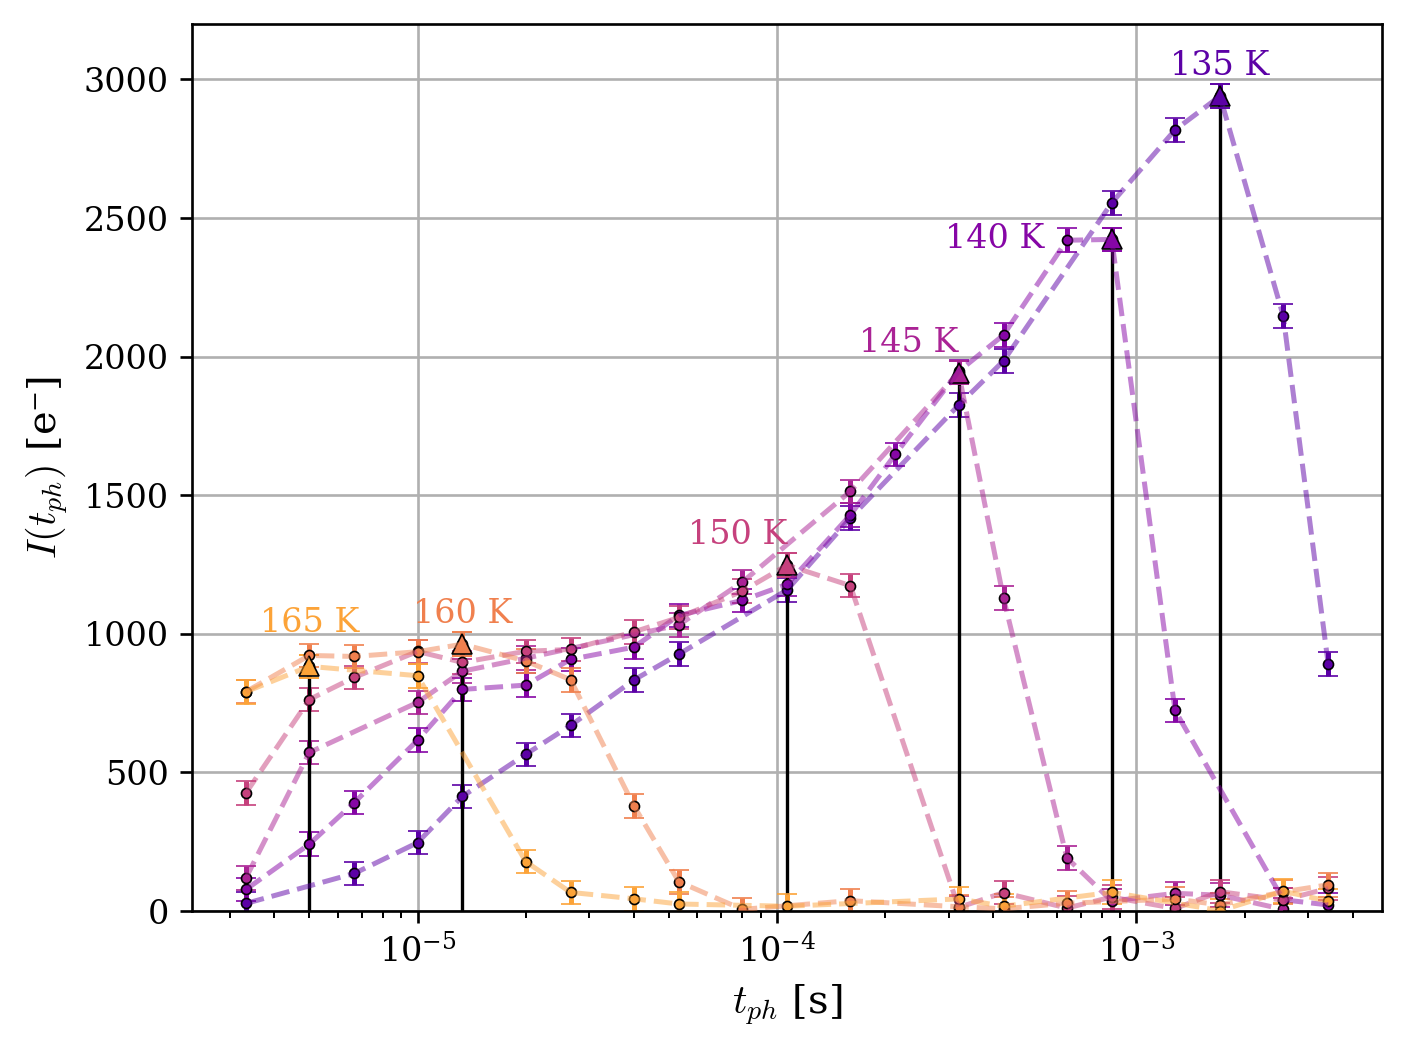

In [245]:
# Graficamos una trampa de ejemplo para varias temperaturas
trampa_ejemplo = (783, 197)
filtro_trampa = (resultados_maximos["Trampa"] == trampa_ejemplo)
colors = plt.cm.ScalarMappable(
    norm=plt.Normalize(127, 175),
    cmap="plasma"
)
text_kwargs_by_temp = {
    165: {"va": "bottom", "ha": "center"},
    160: {"va": "bottom", "ha": "center"},
    150: {"va": "bottom", "ha": "right"},
    140: {"va": "center", "ha": "right"},
    145: {"va": "bottom", "ha": "right"},
    135: {"va": "bottom", "ha": "center"},
}
text_pad_by_temp = {
    165: (0, 100),
    160: (0, 50),
    150: (0, 50),
    140: (-3e-4, 0),
    145: (0, 50),
    135: (0, 50),
}
    
for temp, tph_vals, intensidades, error_vals in zip(
    resultados_maximos.loc[filtro_trampa, "Temperatura"],
    resultados_maximos.loc[filtro_trampa, "tph"],
    resultados_maximos.loc[filtro_trampa, "Intensidad"],
    resultados_maximos.loc[filtro_trampa, "Error Intensidad"],
):
    plt.errorbar(
        tph_vals,
        intensidades,
        yerr=error_vals,
        fmt=".", c=colors.to_rgba(temp),
        mec="k", mew=0.5, capsize=3,
    )
    plt.plot(
        tph_vals,
        intensidades,
        "--", c=colors.to_rgba(temp),
        alpha=0.5, zorder=3,
    )
    max_idx = np.argmax(intensidades)
    plt.vlines(
        tph_vals[max_idx],
        ymin=0, ymax=intensidades[max_idx],
        color="k", lw=1,
    )
    # popt, pcov = curve_fit(
    #     intensidad_func,
    #     tph_vals,
    #     intensidades,
    #     sigma=error_vals,
    #     p0=[tph_vals[max_idx]*np.log(2), 2000]
    # )
    # perr = np.sqrt(np.diag(pcov))
    # tph_dense = np.geomspace(tph_vals.min(), tph_vals.max(), 1000)
    # plt.plot(
    #     tph_dense,
    #     intensidad_func(tph_dense, *popt),
    #     "--",
    #     c=colors.to_rgba(temp),
    # )
    plt.errorbar(
        tph_vals[max_idx],
        intensidades[max_idx],
        yerr=error_vals[max_idx],
        fmt="^", c=colors.to_rgba(temp),
        mec="k", mew=0.5, capsize=3,
    )
    plt.text(
        tph_vals[max_idx] + text_pad_by_temp[temp][0],
        intensidades[max_idx] + text_pad_by_temp[temp][1],
        f"{temp} K",
        c=colors.to_rgba(temp),
        **text_kwargs_by_temp[temp]
    )
plt.grid()
plt.xscale("log")
plt.xlabel("$t_{ph}$ [s]")
plt.ylabel("$I(t_{ph})$ [e⁻]")
plt.ylim(0, 3200)
plt.show()

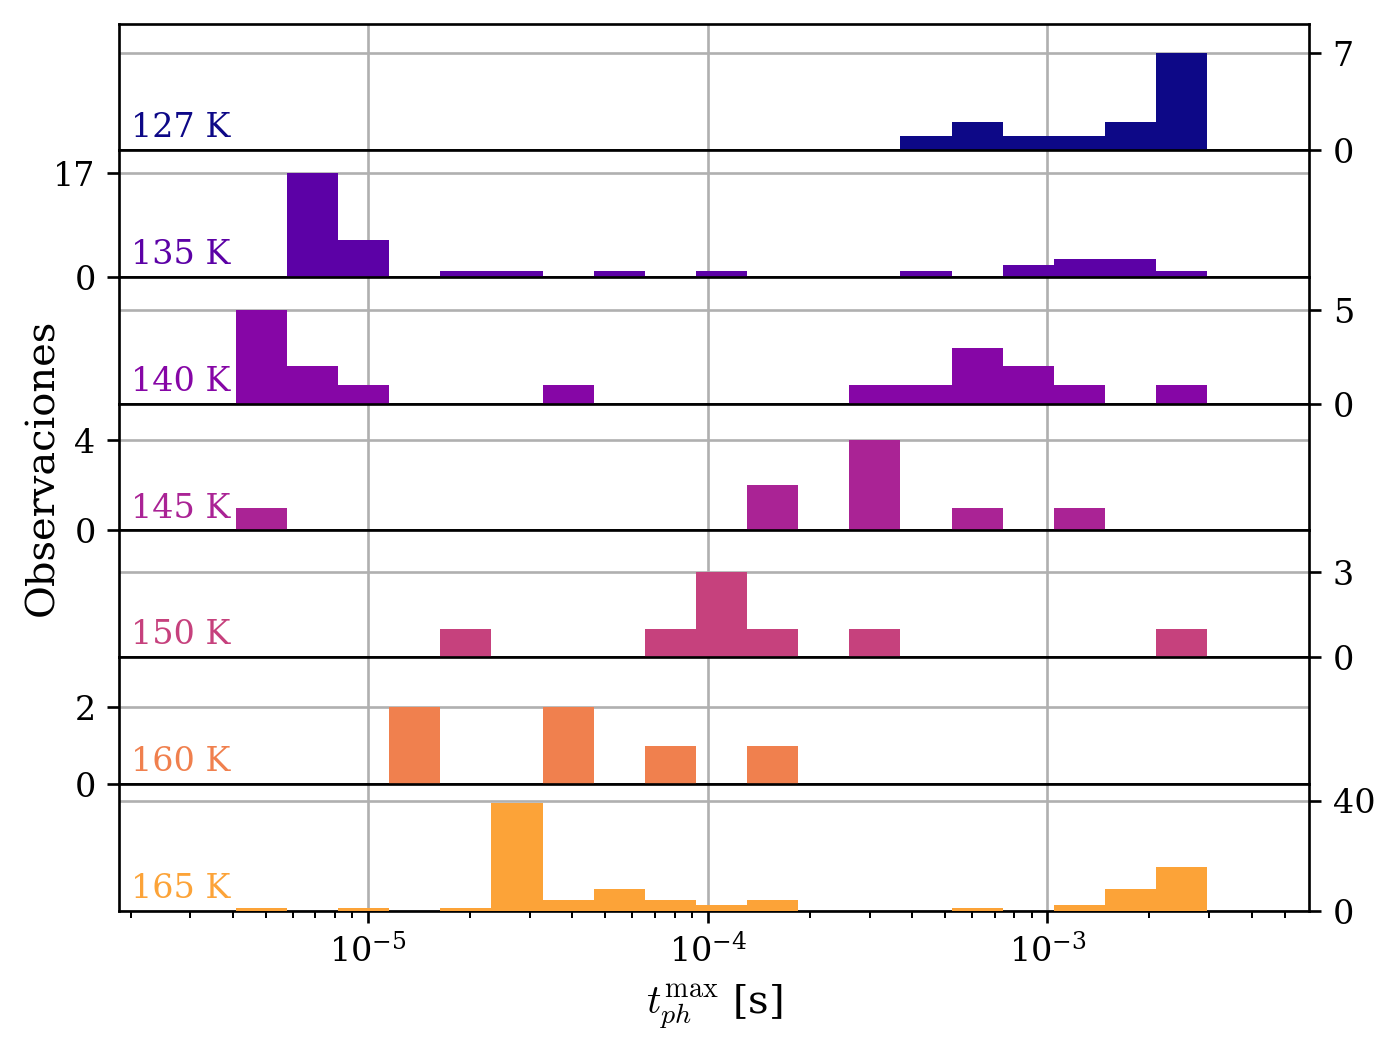

In [282]:
# Gráfico de la distribución de Máximos a medida que aumenta la temperatura
fig, axs = plt.subplots(len(CARPETAS_POR_TEMP), 1, sharex=True,)
# Sin dejar espacio entre los axs
fig.subplots_adjust(hspace=0)
plot_idx = 0
for temperatura, ax in zip(CARPETAS_POR_TEMP.keys(), axs):
    ax.hist(
        resultados_maximos[resultados_maximos["Temperatura"] == temperatura]["t_max"],
        bins=DTPH_BINS/CLOCKS_TO_SEC,
        facecolor=colors.to_rgba(temperatura),
        zorder=5,
    )
    # vals, counts = np.unique(
    #     resultados_maximos[resultados_maximos["Temperatura"] == temperatura]["t_max"],
    #     return_counts=True,
    # )
    # ax.stem(
    #     vals/CLOCKS_TO_SEC,
    #     counts,
        
    # )
    ax.text(
        0.01, 0.05,
        f"{temperatura} K",
        transform=ax.transAxes,
        ha="left", va="bottom", c=colors.to_rgba(temperatura),
    )
    ax.grid()
    ylims = ax.get_ylim()
    ax.set_ylim(0, ylims[1]*1.1 + 1)
    ax.set_yticks([0, int(ylims[1])])
    if temperatura == 145:
        ax.set_ylabel("Observaciones")
    if not plot_idx % 2:
        # ticks a la derecha
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
    plot_idx += 1
ax.set_xscale("log")
ax.set_xlabel("$t_{ph}^\mathrm{max}$ [s]")
plt.show()

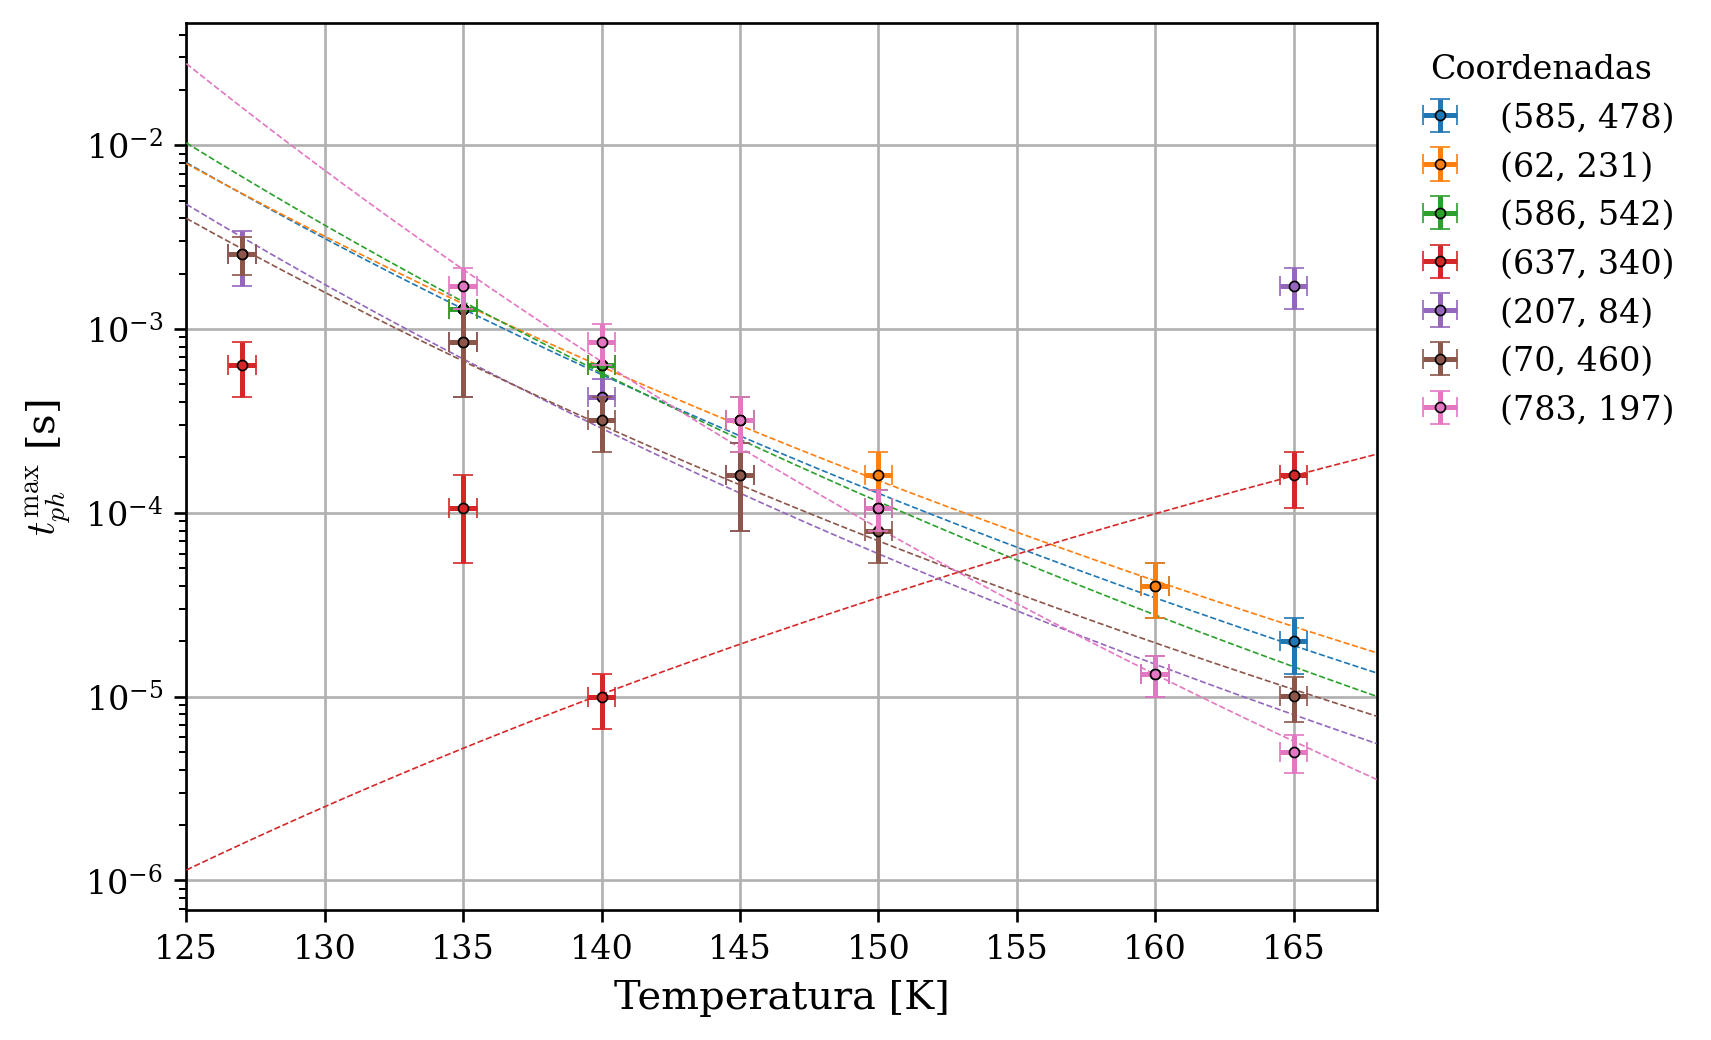

In [290]:
# Buscamos trampas que aparecen en varias temperaturas y graficamos con el ajuste
trampas_unicas = set(trampas_seleccionadas)
trampas_en_muchas_temps = []
temps_dense = np.linspace(125, 168, 1000)
plot_idx = 0
for coord in trampas_unicas:
    if sum(resultados_maximos["Trampa"] == coord) >= 4:
        trampas_en_muchas_temps.append(coord)
        filtro_trampa = (resultados_maximos["Trampa"] == coord)
        temps = resultados_maximos.loc[filtro_trampa, "Temperatura"]
        t_max = resultados_maximos.loc[filtro_trampa, "t_max"]
        t_max_err = resultados_maximos.loc[filtro_trampa, "Error t_max"]
        plt.errorbar(
            temps,
            t_max,
            yerr=t_max_err,
            xerr=0.5,
            fmt=".", label=f"{coord}", c=f"C{plot_idx%10}",
            mec="k", mew=0.5, capsize=3, zorder=12 + plot_idx,
        )
        popt, pcov = curve_fit(
            tau_func,
            temps,
            t_max,
            sigma=t_max_err,
        )
        plt.plot(
            temps_dense,
            tau_func(temps_dense, *popt),
            "--", c=f"C{plot_idx%10}", lw=0.5,
            zorder=3 + plot_idx,
        )
        plot_idx += 1
plt.grid()
plt.legend(title=f"Coordenadas", loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.xlabel("Temperatura [K]")
plt.xlim(temps_dense[0], temps_dense[-1])
plt.yscale("log")
plt.ylabel("$t_{ph}^\mathrm{max}$ [s]")
plt.show()